In [1]:
import numpy as np
import pandas as pd 
import torch
import numpy as np
import torchvision
import random
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.utils.data import Dataset, TensorDataset, DataLoader
from PIL import Image
import sys
from tqdm import tqdm
import warnings 
warnings.filterwarnings('ignore')

In [19]:
# Функции загрузки датасета
def to_categorical(y, num_classes=None, dtype='float32'):
    """
    Аналог from keras.utils.np_utils import to_categorical
    без использования keras.
    Источник - https://github.com/keras-team/keras/blob/master/keras/utils/np_utils.py#L9-L37
    """
    y = np.array(y, dtype='int')
    input_shape = y.shape
    if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
        input_shape = tuple(input_shape[:-1])
    y = y.ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes), dtype=dtype)
    categorical[np.arange(n), y] = 1
    output_shape = input_shape + (num_classes,)
    categorical = np.reshape(categorical, output_shape)
    return categorical

def emotion_count(y_train, classes):
    """
    The function re-classify picture with disgust label into angry label
    """
    emo_classcount = {}
    #print ('Disgust classified as Angry')
    #y_train.loc[y_train == 1] = 0
    #classes.remove('Disgust') # Не удаляем седьмую эмоцию
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

def load_data(sample_split=0.3, usage='Training',classes=['Angry','Happy'], filepath='./fer20131.csv'):
    """
    The function load provided CSV dataset and further reshape, rescale the data for feeding
    """
    df = pd.read_csv(filepath)
    df = df[df.Usage == usage]
    frames = []
    #classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data)*sample_split))
    data = data.loc[rows]
    x = list(data["pixels"])
    X = []
    for i in range(len(x)):
        each_pixel = [int(num) for num in x[i].split()]
        X.append(each_pixel)
    ## reshape into 48*48*1 and rescale
    X = np.array(X)
    X = X.reshape(X.shape[0], 48, 48,1)
    X = X.astype("float32")
    X /= 255
    
    y_train, new_dict = emotion_count(data.emotion, classes)
    y_train = to_categorical(y_train)
    return X, y_train

In [20]:
## Загрузка test,train,validation
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
# Добавляем удаленную в оригинале седьмую эмоцию (Disgust)
emo     = ['Angry', 'Disgust', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

X_test, y_test = load_data(sample_split=1.0,classes=emo,
usage='PrivateTest')

X_train, y_train = load_data(sample_split=1.0,classes=emo,
usage= 'Training')

X_val,y_val = load_data(sample_split=1.0,classes=emo,
usage= 'PublicTest')

In [21]:
# augmentation
train_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=(2, 5)),
    transforms.RandomPerspective(),
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor(),
])

class CustomTensorDataset(Dataset):
    """
    TensorDataset with support of transforms.
    Источник - https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset
    """
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]
        x = np.repeat(x, 3, -1)  # RGB изображение
        if self.transform:
            x = self.transform(x)
        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [22]:
batch_size = 1

tensor_X_test = torch.Tensor(X_test) 
tensor_y_test = torch.Tensor(y_test)
test_dataset = CustomTensorDataset(tensors=(tensor_X_test, tensor_y_test), transform=train_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

tensor_X_train = torch.Tensor(X_train) 
tensor_y_train = torch.Tensor(y_train)
train_dataset = CustomTensorDataset(tensors=(tensor_X_train, tensor_y_train), transform=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


tensor_X_val = torch.Tensor(X_val) 
tensor_y_val = torch.Tensor(y_val)
val_dataset = CustomTensorDataset(tensors=(tensor_X_val, tensor_y_val), transform=train_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


(48, 48, 3)


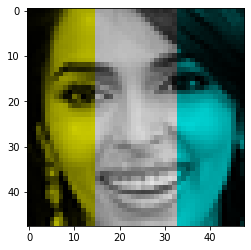

In [23]:
X_batch_test, y_batch_test = next(iter(test_dataloader))
print(X_batch_test[0].numpy().shape)
plt.imshow(X_batch_test[0].numpy());

In [24]:
# Размерности
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(28709, 48, 48, 1)
(28709, 7)
(3589, 48, 48, 1)
(3589, 7)
(3589, 48, 48, 1)
(3589, 7)


In [25]:
def save_data(X_test, y_test, fname=''):
    """
    The function stores loaded data into numpy form for further processing
    """
    np.save( 'X_test' + fname, X_test)
    np.save( 'y_test' + fname, y_test)
save_data(X_test, y_test,"_privatetest6_100pct")
X_fname = 'X_test_privatetest6_100pct.npy'
y_fname = 'y_test_privatetest6_100pct.npy'
X = np.load(X_fname)
y = np.load(y_fname)
print ('Private test set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
# Добавляем удаленную в оригинале седьмую эмоцию (Disgust)
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print (zip(labels, counts))

Private test set


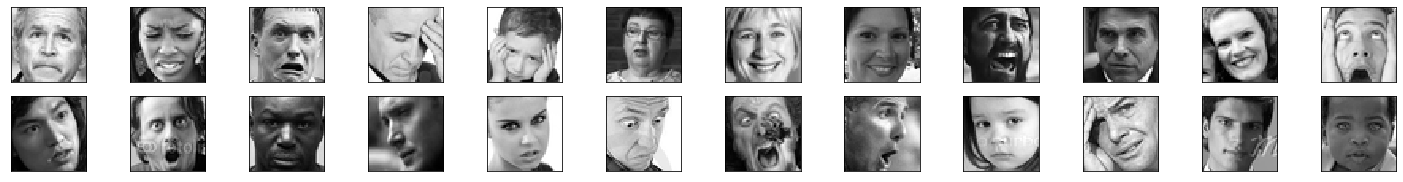

In [26]:
def overview(start, end, X):
    """
    The function is used to plot first several pictures for overviewing inputs format
    """
    fig = plt.figure(figsize=(20,20))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img[0,:,:,0], cmap=plt.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
overview(0,23, X)

In [27]:
y_train = y_train 
y_public = y_val 
y_private = y_test 
y_train_labels  = [np.argmax(lst) for lst in y_train]
y_public_labels = [np.argmax(lst) for lst in y_public]
y_private_labels = [np.argmax(lst) for lst in y_private]

In [28]:
!pip install brewer2mpl
import brewer2mpl

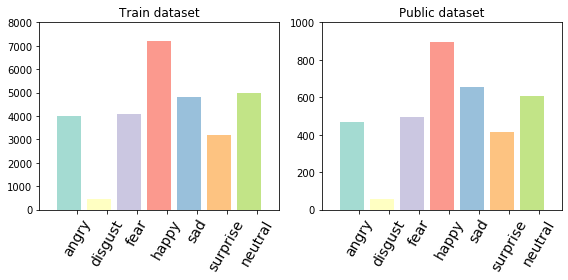

In [29]:
def plot_distribution(y1, y2, data_names, ylims =[1000,1000]): 
    """
    The function is used to plot the distribution of the labels of provided dataset 
    """
    colorset = brewer2mpl.get_map('Set3', 'qualitative', 7).mpl_colors
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,8), np.bincount(y1), color=colorset, alpha=0.8)
    ax1.set_xticks(np.arange(1.25,8.25,1))
    ax1.set_xticklabels(labels, rotation=60, fontsize=14)
    ax1.set_xlim([0, 8])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(np.arange(1,8), np.bincount(y2), color=colorset, alpha=0.8)
    ax2.set_xticks(np.arange(1.25,8.24,1))
    ax2.set_xticklabels(labels, rotation=60, fontsize=14)
    ax2.set_xlim([0, 8])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    plt.tight_layout()
    plt.show()

plot_distribution(y_train_labels, y_public_labels, \
                  ['Train dataset', 'Public dataset'], \
                  ylims =[8000,1000]) 

In [30]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.reshape(-1, 3, 48, 48)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, torch.max(labels, 1)[1])
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [31]:
model = models.resnet18(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 7)  # 7 эмоций

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [32]:
train_model(model, loss, optimizer, scheduler, num_epochs=2);

Epoch 0/1:


100%|███████████████████████████████████████████████████████████████████████████| 28709/28709 [02:43<00:00, 176.09it/s]


train Loss: 2.0935 Acc: 0.0947


100%|█████████████████████████████████████████████████████████████████████████████| 3589/3589 [00:18<00:00, 190.12it/s]


val Loss: 6.2143 Acc: 0.1212
Epoch 1/1:


100%|███████████████████████████████████████████████████████████████████████████| 28709/28709 [02:42<00:00, 176.16it/s]


train Loss: 2.0908 Acc: 0.0975


100%|█████████████████████████████████████████████████████████████████████████████| 3589/3589 [00:18<00:00, 190.79it/s]


val Loss: 7.1930 Acc: 0.2440


In [33]:
from sklearn.metrics import f1_score
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
test_predictions = []
test_predictions_real = []
for inputs, labels in tqdm(test_dataloader):
    inputs = inputs.reshape(-1, 3, 48, 48)
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(torch.max(torch.nn.functional.softmax(preds, dim=1).data.cpu(), 1)[1])
    test_predictions_real.append(torch.max(labels.data.cpu(), 1)[1])
    
test_predictions = np.concatenate(test_predictions)
test_predictions_real = np.concatenate(test_predictions_real)

100%|█████████████████████████████████████████████████████████████████████████████| 3589/3589 [00:17<00:00, 200.12it/s]


In [35]:
f1_score(test_predictions_real, test_predictions, average='micro')

0.1691278907773753

In [36]:
X_batch_test, y_batch_test = next(iter(test_dataloader))
with torch.set_grad_enabled(False):
    inputs = X_batch_test[0]
    inputs = inputs.reshape(-1, 3, 48, 48)
    inputs= inputs.to(device)
    preds = model(inputs)
result = torch.max(torch.nn.functional.softmax(preds, dim=1).data.cpu(), 1)[1] 


2 Fear


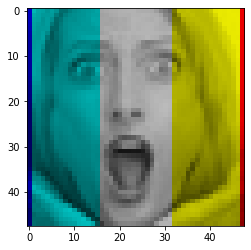

In [41]:
print(result.numpy()[0], emo[result])
plt.imshow(X_batch_test[0].numpy());